## Notebook Idea

The goal of this workbook is to test the feasibility of the following project idea:

Core Question: Who owns the ball? The position reassignment of possession.

Phase 1: Define possession by position. The unit of analysis here would be match-team-position combo. We can compute metrics like:
* touch share: position touches/team touches
* possession action share: position possession events / team total
* progression share: progressive actions (passes, carries, etc.)  by position / team total
* playing out of pressure (i.e., carry or pass instead of booting it down the field or losing possession)
* average touch location (x, y)
* we can incorporate xG or some sort of a threat metric calculation
From these we can compute some sort of aggregated scores, like game control score (by position) and field position score (like how far away they are from the opponent's goal).

Phase 2: Visualizations
* simple bar charts covering things like the position on the X axis and the various metrics computed above on the y axis. We can facet these by season or competition, depending on the route we want to go to.
* average touch location by position: here we can go crazy on the visuals, maybe import some soccer visual libraries (if there are any) and make it look cool. Again, we should facet on something, like time, to show how positions have changed through time., or by league, or why not even both.
* here we can plot the measures and aggregated scores. by position and again facet on time and competition. this goes to answer how has the game evolved through time with respect to the various position. what positions now drive the play.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = "../data/Statsbomb"

## Read in data

### Load matches and pick just one competition for feasibility analysis

In [2]:
matches = pd.read_parquet(f"{DATA_DIR}/matches.parquet")
matches.shape

(3464, 36)

In [3]:
matches[['competition_name']].value_counts()

competition_name       
La Liga                    868
Ligue 1                    435
Premier League             418
Serie A                    381
1. Bundesliga              340
FA Women's Super League    326
FIFA World Cup             147
Women's World Cup          116
Indian Super league        115
UEFA Euro                  102
UEFA Women's Euro           62
African Cup of Nations      52
NWSL                        36
Copa America                32
Champions League            18
Major League Soccer          6
UEFA Europa League           3
Copa del Rey                 3
Liga Profesional             2
North American League        1
FIFA U20 World Cup           1
Name: count, dtype: int64

In [4]:
matches[matches['competition_name']=='Premier League']['season_name'].value_counts()
# this is concerning because if we want to limit to the premier league and do a time analysis, we have
# two problems. 1) there is really only a single season of information; and 2) that season is 10 years ago.
# let's try la liga.

season_name
2015/2016    380
2003/2004     38
Name: count, dtype: int64

In [5]:
matches[matches['competition_name']=='La Liga']['season_name'].value_counts()
# la liga is a bit better

season_name
2015/2016    380
2014/2015     38
2011/2012     37
2017/2018     36
2009/2010     35
2020/2021     35
2016/2017     34
2018/2019     34
2010/2011     33
2019/2020     33
2012/2013     32
2013/2014     31
2008/2009     31
2007/2008     28
2006/2007     26
2005/2006     17
2004/2005      7
1973/1974      1
Name: count, dtype: int64

### Lock the matches to do this on

In [6]:
la_liga_matches = matches[
    (matches["competition_name"] == "La Liga") &
    (matches["season_name"].isin(["2009/2010", "2015/2016", "2019/2020"]))
]

la_liga_matches.groupby("season_name")["match_id"].nunique()

season_name
2009/2010     35
2015/2016    380
2019/2020     33
Name: match_id, dtype: int64

### Load the events and limit to sample

In [7]:
events = pd.read_parquet(f"{DATA_DIR}/events.parquet")
events.shape

(12188949, 112)

In [8]:
events.head(1)

,id,index_num,period,minute,second,timestamp,duration,location_x,location_y,possession,...,block_save_block,ball_recovery_offensive,ball_recovery_failure,miscontrol_aerial_won,substitution_replacement_id,substitution_replacement_name,substitution_outcome,fifty_fifty_outcome,bad_behaviour_card,injury_stoppage_in_chain
0,9f6e2ecf-6685-45df-a62e-c2db3090f6c1,1,1,0,0,00:00:00,0.0,NaN,NaN,1,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False


In [9]:
match_ids = set(la_liga_matches["match_id"])

events_ll = events[events["match_id"].isin(match_ids)]
events_ll.shape

(1552807, 112)

In [10]:
events_ll.shape[0]/events.shape[0] #so, this sample size covers about 13% of the entire events data, not bad

0.12739465888322282

In [11]:
possession_events = [
    "Pass",
    "Carry",
    "Ball Receipt*",
    "Dribble",
] # limit to just these for now, it's a feasibility analysis, nothing more at this point

poss_events = events_ll[events_ll["type"].isin(possession_events)]
poss_events["type"].value_counts()

type
Pass             437890
Ball Receipt*    397827
Carry            336070
Dribble           17326
Name: count, dtype: int64

### Load lineups and create position bins

In [12]:
lineups = pd.read_parquet(f"{DATA_DIR}/lineups.parquet")
lineups.shape

(165820, 17)

In [13]:
lineups.head(1)

,match_id,team_id,player_id,player_name,player_nickname,jersey_number,country_id,country_name,team_name,position_name,from_time,to_time,from_period,to_period,card_time,card_type,card_reason
0,15946,206,6839,Daniel Alejandro Torres Rojas,Dani Torres,16,49.0,Colombia,Deportivo Alavés,Center Defensive Midfield,00:00,67:48,1.0,2.0,09:15,Yellow Card,Foul Committed


In [14]:
POSITION_BINS = {
    # ======================
    # CENTER BACKS
    # ======================
    "Center Back": "Center Back",
    "Left Center Back": "Center Back",
    "Right Center Back": "Center Back",

    # ======================
    # FULLBACKS / WINGBACKS
    # ======================
    "Left Back": "Fullback",
    "Right Back": "Fullback",
    "Left Wing Back": "Fullback",
    "Right Wing Back": "Fullback",

    # ======================
    # DEFENSIVE MIDFIELD
    # ======================
    "Center Defensive Midfield": "Defensive Midfield",
    "Left Defensive Midfield": "Defensive Midfield",
    "Right Defensive Midfield": "Defensive Midfield",

    # ======================
    # CENTRAL MIDFIELD
    # ======================
    "Center Midfield": "Central Midfield",
    "Left Center Midfield": "Central Midfield",
    "Right Center Midfield": "Central Midfield",

    # ======================
    # ATTACKING MIDFIELD
    # ======================
    "Center Attacking Midfield": "Attacking Midfield",
    "Left Attacking Midfield": "Attacking Midfield",
    "Right Attacking Midfield": "Attacking Midfield",

    # ======================
    # WIDE FORWARDS / WIDE MIDFIELD
    # ======================
    "Left Wing": "Wide Forward",
    "Right Wing": "Wide Forward",
    "Left Midfield": "Wide Forward",
    "Right Midfield": "Wide Forward",

    # ======================
    # STRIKERS
    # ======================
    "Center Forward": "Striker",
    "Left Center Forward": "Striker",
    "Right Center Forward": "Striker",
    "Secondary Striker": "Striker",

    # ======================
    # GOALKEEPER
    # ======================
    "Goalkeeper": "Goalkeeper",
}


In [15]:
lineups["pos_bin"] = lineups["position_name"].map(POSITION_BINS)
lineups

,match_id,team_id,player_id,player_name,player_nickname,jersey_number,country_id,country_name,team_name,position_name,from_time,to_time,from_period,to_period,card_time,card_type,card_reason,pos_bin
0,15946,206,6839,Daniel Alejandro Torres Rojas,Dani Torres,16,49.0,Colombia,Deportivo Alavés,Center Defensive Midfield,00:00,67:48,1.0,2.0,09:15,Yellow Card,Foul Committed,Defensive Midfield
1,15946,206,6855,Guillermo Alfonso Maripán Loaysa,Guillermo Maripán,6,45.0,Chile,Deportivo Alavés,Left Center Back,00:00,NaN,1.0,NaN,40:46,Yellow Card,Bad Behaviour,Center Back
2,15956,217,5213,Gerard Piqué Bernabéu,Gerard Piqué,3,214.0,Spain,Barcelona,Right Center Back,00:00,NaN,1.0,NaN,59:01,Yellow Card,Foul Committed,Center Back
3,15956,901,6760,Enes Ünal,NaN,9,233.0,Turkey,Real Valladolid,Right Center Forward,00:00,69:51,1.0,2.0,48:43,Yellow Card,Foul Committed,Striker
4,15973,217,8206,Arturo Erasmo Vidal Pardo,Arturo Vidal,22,45.0,Chile,Barcelona,Right Center Midfield,70:46,70:49,2.0,2.0,87:18,Yellow Card,Foul Committed,Central Midfield
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165815,3878555,224,40458,Rubens Fernando Moedim,Rubinho,34,31.0,Brazil,Juventus,NaN,NaN,NaN,NaN,NaN,65:26,Red Card,Bad Behaviour,NaN
165816,3920413,4934,3417,Saidy Janko,NaN,17,83.0,Gambia,Gambia,NaN,NaN,NaN,NaN,NaN,85:56,Yellow Card,Bad Behaviour,NaN
165817,3900528,146,10448,Adam Ounas,NaN,33,4.0,Algeria,Bordeaux,NaN,NaN,NaN,NaN,NaN,91:03,Yellow Card,Bad Behaviour,NaN
165818,3939988,3565,123554,Jordy Josué Caicedo Medina,NaN,19,65.0,Ecuador,Ecuador,NaN,NaN,NaN,NaN,NaN,95:46,Yellow Card,Bad Behaviour,NaN


In [16]:
lineups[['position_name', 'pos_bin']].drop_duplicates()

,position_name,pos_bin
0,Center Defensive Midfield,Defensive Midfield
1,Left Center Back,Center Back
2,Right Center Back,Center Back
3,Right Center Forward,Striker
4,Right Center Midfield,Central Midfield
5,Right Defensive Midfield,Defensive Midfield
6,Left Back,Fullback
8,Left Defensive Midfield,Defensive Midfield
11,Right Back,Fullback
14,Center Attacking Midfield,Attacking Midfield


In [17]:
lineups_ll = lineups[lineups["match_id"].isin(match_ids)]
lineups_ll.shape

(19645, 18)

In [18]:
player_pos = (
    lineups_ll[
        ["match_id", "team_id", "player_id", "pos_bin"]
    ]
    .drop_duplicates()
)

player_pos.head()
# for now, let's ignore substitutions

,match_id,team_id,player_id,pos_bin
8300,265839,213,3253,Center Back
8301,265839,213,10476,Center Back
8302,265839,217,4324,Fullback
8303,265839,217,5213,Center Back
8304,265839,217,6379,Central Midfield


In [19]:
player_pos.shape

(17757, 4)

In [20]:
player_pos[['match_id', 'team_id', 'player_id']].drop_duplicates().shape

(15971, 3)

okay, so here is one thing we're going to have to talk through.. a player can play multiple positions per game
we need to figure out how to attribute a position to a player. for now, we can just use the starting position
because it's easier. in the future, we can do things like a dominant position throughout the game. or even more
overachieving , split player actions across positions by weighing actions by time spent in each position. 
the latter would involve a ton of code, but will be the most accurate for the analysis, if done right. 

In [21]:
player_pos_start = (
    lineups_ll
    .drop_duplicates(
        subset=["match_id", "team_id", "player_id"],
        keep="first"
    )[
        ["match_id", "team_id", "player_id", "pos_bin"]
    ]
)

player_pos_start.shape

(15971, 4)

In [22]:
player_pos_start[
    ["match_id", "team_id", "player_id"]
].duplicated().any()

np.False_

### Join events data with the lineup bins

In [23]:
poss_events_pos = poss_events.merge(
    player_pos_start,
    on=["match_id", "team_id", "player_id"],
    how="left",
)

In [24]:
poss_events_pos.shape[0] == poss_events.shape[0]

True

In [25]:
poss_events_pos["pos_bin"].isna().mean()

np.float64(0.0)

In [26]:
poss_events_pos = poss_events_pos.dropna(subset=["pos_bin"])
poss_events_pos.shape

(1189113, 113)

In [27]:
poss_events_pos.head(1)

,id,index_num,period,minute,second,timestamp,duration,location_x,location_y,possession,...,ball_recovery_offensive,ball_recovery_failure,miscontrol_aerial_won,substitution_replacement_id,substitution_replacement_name,substitution_outcome,fifty_fifty_outcome,bad_behaviour_card,injury_stoppage_in_chain,pos_bin
0,f9706b37-a2b5-44a8-90ba-3cdb5aeaba1b,5,1,0,0,00:00:00.509,0.9991,60.0,40.0,2,...,False,False,False,NaN,NaN,NaN,NaN,NaN,False,Striker


In [28]:
poss_events_pos.columns

Index(['id', 'index_num', 'period', 'minute', 'second', 'timestamp',
       'duration', 'location_x', 'location_y', 'possession',
       ...
       'ball_recovery_offensive', 'ball_recovery_failure',
       'miscontrol_aerial_won', 'substitution_replacement_id',
       'substitution_replacement_name', 'substitution_outcome',
       'fifty_fifty_outcome', 'bad_behaviour_card', 'injury_stoppage_in_chain',
       'pos_bin'],
      dtype='str', length=113)

### Compute touch share with temporal aspect

In [29]:
poss_events_pos = poss_events_pos.merge(
    matches[["match_id", "season_name"]],
    on="match_id",
    how="left"
)

touches_by_pos = (
    poss_events_pos
    .groupby(["season_name", "match_id", "team_id", "pos_bin"])
    .size()
    .reset_index(name="touches")
)

team_touches = (
    touches_by_pos
    .groupby(["season_name", "match_id", "team_id"])["touches"]
    .sum()
    .reset_index(name="team_touches")
)

touches_by_pos = touches_by_pos.merge(
    team_touches,
    on=["season_name", "match_id", "team_id"],
    how="left"
)

touches_by_pos["touch_share"] = (
    touches_by_pos["touches"] / touches_by_pos["team_touches"]
)

print(touches_by_pos["touch_share"].describe())

avg_touch_share_season = (
    touches_by_pos
    .groupby(["season_name", "pos_bin"])["touch_share"]
    .mean()
    .reset_index()
)

avg_touch_share_season[
    avg_touch_share_season["pos_bin"].notna()
].sort_values(
    ["pos_bin", "season_name"]
)

count    6035.000000
mean        0.148467
std         0.068779
min         0.001735
25%         0.087480
50%         0.162080
75%         0.202642
max         0.336522
Name: touch_share, dtype: float64


,season_name,pos_bin,touch_share
0,2009/2010,Attacking Midfield,0.120841
8,2015/2016,Attacking Midfield,0.109041
16,2019/2020,Attacking Midfield,0.087137
1,2009/2010,Center Back,0.147281
9,2015/2016,Center Back,0.155999
17,2019/2020,Center Back,0.179287
2,2009/2010,Central Midfield,0.222346
10,2015/2016,Central Midfield,0.210920
18,2019/2020,Central Midfield,0.205770
3,2009/2010,Defensive Midfield,0.137079


### Compute progression share with temporal aspect

In [30]:
prog_events = poss_events_pos[
    poss_events_pos["type"].isin(["Pass", "Carry", "Dribble"])
].copy()

prog_events["is_progressive"] = (
    (prog_events["type"] == "Pass") & (prog_events["pass_end_location_x"] - prog_events["location_x"] >= 10)
) | (
    (prog_events["type"] == "Carry") & (prog_events["carry_end_location_x"] - prog_events["location_x"] >= 10)
)

prog_by_pos = (
    prog_events[prog_events["is_progressive"]]
    .groupby(["season_name", "match_id", "team_id", "pos_bin"])
    .size()
    .reset_index(name="prog_actions")
)

team_prog = (
    prog_by_pos
    .groupby(["season_name", "match_id", "team_id"])["prog_actions"]
    .sum()
    .reset_index(name="team_prog_actions")
)

prog_by_pos = prog_by_pos.merge(
    team_prog,
    on=["season_name", "match_id", "team_id"],
    how="left"
)

prog_by_pos["progression_share"] = (
    prog_by_pos["prog_actions"] / prog_by_pos["team_prog_actions"]
)

avg_prog_share_season = (
    prog_by_pos
    .groupby(["season_name", "pos_bin"])["progression_share"]
    .mean()
    .reset_index()
)

### Combine the two metrics

In [31]:
avg_touch_share_season.shape

(24, 3)

In [32]:
avg_prog_share_season.shape

(24, 3)

In [33]:
combo = avg_touch_share_season.merge(
    avg_prog_share_season,
    on=["season_name", "pos_bin"],
    how="inner"
)

combo.shape

(24, 4)

In [34]:
combo.head(5)

,season_name,pos_bin,touch_share,progression_share
0,2009/2010,Attacking Midfield,0.120841,0.065959
1,2009/2010,Center Back,0.147281,0.215587
2,2009/2010,Central Midfield,0.222346,0.189168
3,2009/2010,Defensive Midfield,0.137079,0.116374
4,2009/2010,Fullback,0.187117,0.212076


### Plots

In [35]:
def plot_metric_over_time(
    df,
    metric_col,
    title,
    ylabel,
    annotation_season="2015/2016",
):
    plot_df = df.dropna(subset=["pos_bin"]).copy()

    # Order legend by final season importance
    final_season = plot_df["season_name"].max()
    order = (
        plot_df[plot_df["season_name"] == final_season]
        .sort_values(metric_col, ascending=False)["pos_bin"]
    )

    plt.figure(figsize=(12, 6))

    sns.lineplot(
        data=plot_df,
        x="season_name",
        y=metric_col,
        hue="pos_bin",
        hue_order=order,
        marker="o"
    )

    plt.axvline(annotation_season, color="gray", linestyle="--", alpha=0.5)
    plt.text(
        annotation_season,
        plot_df[metric_col].max(),
        title,
        ha="center",
        va="top",
        fontsize=10,
    )

    plt.title(title)
    plt.xlabel("Season")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(title="Position", bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()


In [36]:
def plot_metric_delta(
    df,
    metric_col,
    start_season,
    end_season,
    title,
    xlabel,
):
    delta_df = (
        df
        .pivot(index="pos_bin", columns="season_name", values=metric_col)
    )

    delta_df["delta"] = delta_df[end_season] - delta_df[start_season]

    delta_df["delta"].sort_values().plot(
        kind="barh",
        figsize=(8, 6),
        title=title
    )

    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()


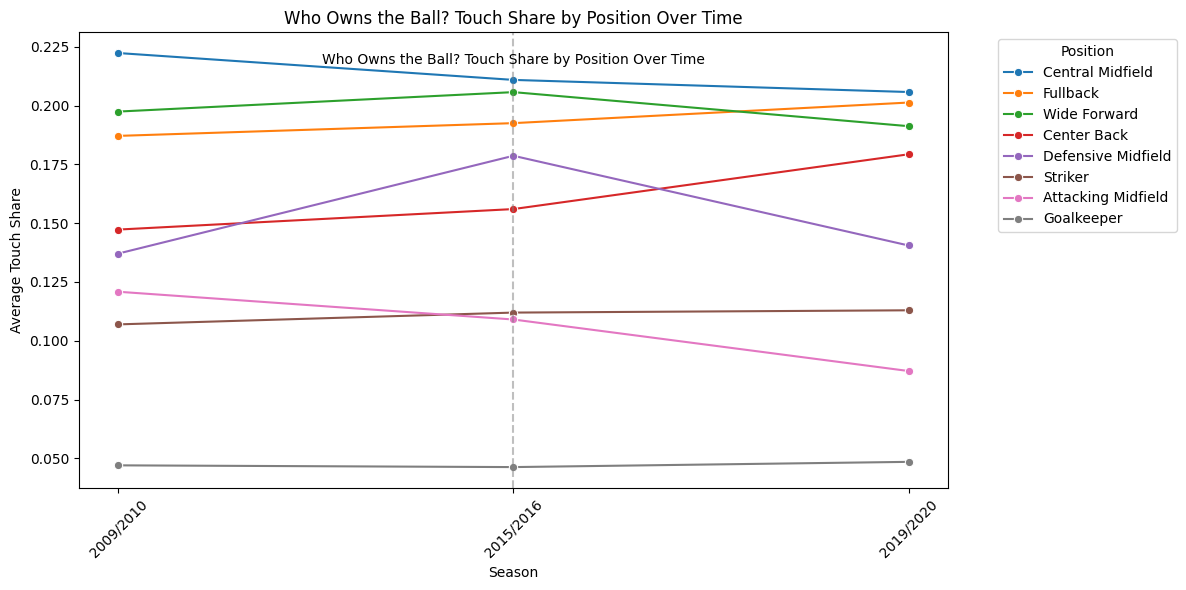

In [37]:
plot_metric_over_time(
    avg_touch_share_season,
    metric_col="touch_share",
    title="Who Owns the Ball? Touch Share by Position Over Time",
    ylabel="Average Touch Share",
)

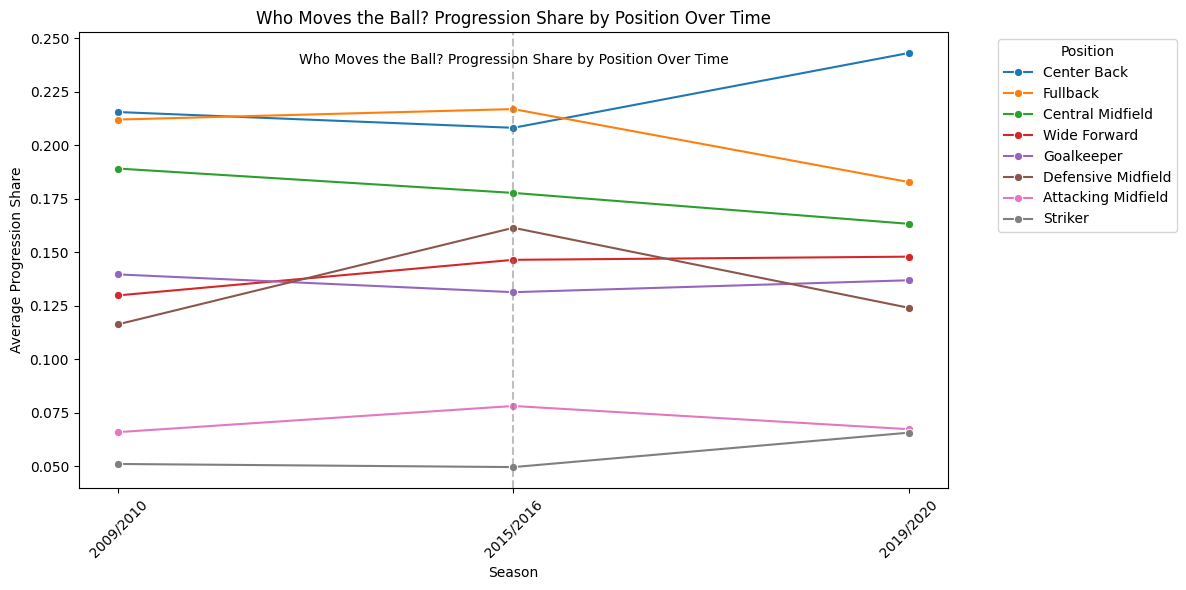

In [38]:
plot_metric_over_time(
    avg_prog_share_season,
    metric_col="progression_share",
    title="Who Moves the Ball? Progression Share by Position Over Time",
    ylabel="Average Progression Share",
)

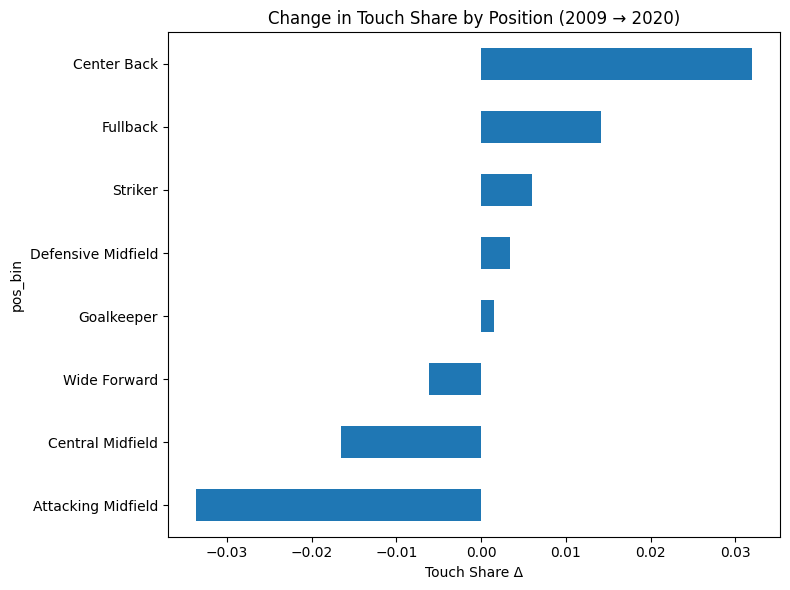

In [39]:
plot_metric_delta(
    avg_touch_share_season,
    metric_col="touch_share",
    start_season="2009/2010",
    end_season="2019/2020",
    title="Change in Touch Share by Position (2009 → 2020)",
    xlabel="Touch Share Δ",
)

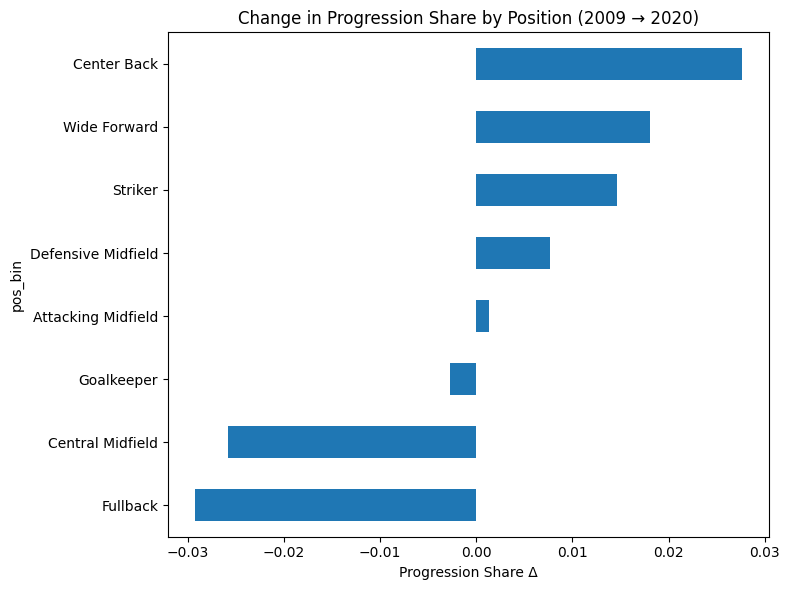

In [40]:
plot_metric_delta(
    avg_prog_share_season,
    metric_col="progression_share",
    start_season="2009/2010",
    end_season="2019/2020",
    title="Change in Progression Share by Position (2009 → 2020)",
    xlabel="Progression Share Δ",
)

### Key Findings from the Touch & Progression Analysis

#### Attacking Midfield
Clear and consistent decline since 2009 in both touch share and progression share.
Creative control is no longer centralized in advanced midfield zones.

#### Center Backs
The biggest absolute gainers in both ball ownership and progression responsibility.
Center backs are no longer just circulation hubs — they are now primary drivers of forward progression, especially post-2015.

#### Fullbacks
Touch share rises steadily over time, but progression share declines.  
This suggests a role shift: fullbacks are increasingly involved in buildup and retention (inverted roles, overload support).
while actual forward progression is redistributed to center backs and wide forwards.

#### Strikers
Largely flat in both touch and progression share.  
Modern strikers remain finishers and space manipulators rather than organizers.

#### Big Picture Takeaway
All metrics are normalized within teams, so this isn’t about who has more possession overall —  
it’s about where possession and progression responsibility lives on the pitch
From 2009 → 2020, control has shifted backward and outward, away from the #10 and toward the back line.

### Next steps

1. Expand possession definition  
   Right now, we’re using touches as a proxy for possession. Next steps:  
   - Add possession actions (passes + carries + dribbles)  
   - Tweak progressive actions (forward passes, carries > X meters)  

   This separates safe circulation vs progression and strengthens the argument that some positions don’t just touch the ball more — they move it.

2. Expand analysis across leagues and seasons  
   To actually claim evolution, we need to:  
   - Include multiple seasons per league (e.g. 2009 → 2015 → 2020)  
   - Expand beyond a single league (e.g. Premier League vs La Liga)  

   This allows us to:  
   - Distinguish global tactical shifts from league-specific styles  
   - Do some dope visualizations  

3. Control for context  
   Optionally segment by:  
   - team strength (would need some proxy for this... perhaps seeing if we can get data on current standings or if not possible, something more trivial)  
   - game state (winning/drawing/losing)  
   - competition / league  

   This would allow for a deeper meaning and tactical analysis, but also for some really dope visualizations.

4. Spatial analysis  
   - Average touch maps by position bin  
   - Heatmaps showing how touch locations shift over time  
   - Compare 2009 vs 2020 positional “centers of gravity”  

5. Build composite scores  
   Instead of many metrics:  
   - Create a Game Control Score per position (weighted touches + progression + threat)  
     - We can do thinks like:  
       - Game control score = 0.4 * touch_share + 0.4 * progression_share + 0.2 * forward_action_rate  
       - Creative control score = 0.5 * xGChain_share + 0.3 * final_third_entries + 0.2 * key_pass_share  
   - Create a Field Position Score (average distance to goal, xThreat involvement)  

   This lets us say things like: “Control moved from the #10 to the back line.”

6. Visualization polish / interactivity  
   - Streamlit
